In [1]:
import os
import os.path
import pickle

import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix

In [2]:
NOTE = '全特徴量を使用したLightGBM.バランス指定、カテゴリ未指定'

N = 5
CV = f'Stratified-Kfold(K={N})'

notebook_name = '018'
OUTPUT_DIR = os.path.basename(notebook_name)
SUB_FILENAME = notebook_name[:3] + '_submission.csv'
assert(SUB_FILENAME not in pd.read_csv('submissions.csv').filename.tolist())
print(SUB_FILENAME, OUTPUT_DIR)
if not os.path.isdir(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

SEED = 1
CATEGORICAL_FEATURES =  [
        'batterID', 'pitcherID', 'Match',
        'isBatterHandLeft', 'isPitcherHandLeft', 'isBatterPitcher',
        'isBottom', 'batterTeam', 'pitcherTeam'
    ]

018_submission.csv 018


In [3]:
def get_estimator(*,
                  categorical_features=None,
                  discrete_features=None,
                  features=None) -> Pipeline:
    return Pipeline(steps=[
        ('estimator', LGBMClassifier(n_estimators=200,
                                     importance_type='gain',
                                     class_weight='balanced',
                                     objective='cross_entropy',
                                     learning_rate=0.01,
                                     random_state=SEED))
         ]
    )

In [4]:
train = pd.read_csv(os.path.join('001_EDA', 'train_data_preprocessed.csv'))
test = pd.read_csv(os.path.join('001_EDA', 'test_data_preprocessed.csv'))

In [5]:
# for c in CATEGORICAL_FEATURES:
#     assert(train[c].isin(test[c]).sum() == train.shape[0])
#     assert(test[c].isin(train[c]).sum() == test.shape[0])

# train = pd.get_dummies(train, columns=CATEGORICAL_FEATURES, drop_first=True)
# test = pd.get_dummies(test, columns=CATEGORICAL_FEATURES, drop_first=True)

# assert(set(train.columns.tolist()) - set(test.columns.tolist()) == {'y'})
# assert(set(test.columns.tolist()) - set(train.columns.tolist()) == set())

In [6]:
# categorical_features = []
# for c in CATEGORICAL_FEATURES:
#     categorical_features += [c_ for c_ in train.columns if c_.startswith(f'{c}_')]
categorical_features = CATEGORICAL_FEATURES
categorical_features

['batterID',
 'pitcherID',
 'Match',
 'isBatterHandLeft',
 'isPitcherHandLeft',
 'isBatterPitcher',
 'isBottom',
 'batterTeam',
 'pitcherTeam']

In [7]:
features = [c for c in train.columns if c not in ('id', 'y')]
assert(set(features) - set(test.columns.tolist()) == set())

In [8]:
discrete_features = [f for f in features if f not in categorical_features]
discrete_features

['totalPitchingCount',
 'B',
 'S',
 'O',
 'b1',
 'b2',
 'b3',
 'inningNo',
 'numRunners',
 'pitcherHoursElapsed',
 'pitcherNumGamesParticipated',
 'batterHoursElapsed',
 'batterNumGamesParticipated',
 'ballPositionLabel__no_data__',
 'ど真ん中',
 '内角中心',
 '内角低め',
 '内角高め',
 '外角中心',
 '外角低め',
 '外角高め',
 '真ん中低め',
 '真ん中高め',
 'ballPositionLabeld1',
 'ballPositionLabeld2',
 'ballPositionLabeld3',
 'ballPositionLabeld4',
 'ballPositionLabeld5',
 'ballPositionLabeld6',
 'ballPositionLabeld7',
 'ballPositionLabeld8',
 'ballPositionLabeld9',
 'ballPositionLabeld10',
 'ballPositionLabeld11',
 'ballPositionLabeld12',
 'ballPositionLabeld13',
 'ballPositionLabeld14',
 'ballPositionLabeld15',
 'ballPositionLabeld16',
 'ballPositionLabeld17',
 'ballPositionLabeld18',
 'ballPositionLabeld19',
 'ballPositionLabeld20',
 'ballPositionLabeld21',
 'ballPositionLabeld22',
 'ballPositionLabeld23',
 'ballPositionLabeld24',
 'ballPositionLabeld25',
 'ballPositionLabeld26',
 'ballPositionLabeld27',
 'ballPositionLabe

In [9]:
%%time
splitter = StratifiedKFold(shuffle=True, random_state=SEED, n_splits=N)
cv_pred_dfs = []
pred_dfs = []
metrics = {'train': [], 'valid': []}
models = []
for i, (train_idx, valid_idx) in enumerate(splitter.split(train, train.y)):
    id_train, X_train, y_train, id_valid, X_valid, y_valid = (
        train.iloc[train_idx].id,
        train.iloc[train_idx][features],
        train.iloc[train_idx].y,
        train.iloc[valid_idx].id,
        train.iloc[valid_idx][features],
        train.iloc[valid_idx].y,
    )
    clf = get_estimator()
    clf.fit(X_train, y_train, estimator__feature_name=features)
    models.append(clf)
    # Evaluate (trian set)
    pred_train = clf.predict(X_train)
    pred_train_df = pd.DataFrame(
        {
            'id': id_train,
            'actual': y_train,
            'prediction': pred_train,
        }
    )
    pred_train_df['train'] = 0
    print('*' * 10 + f'Confusion matrix for train set (Fold {i + 1})' + '*' * 10)
    print(confusion_matrix(y_train, pred_train))
    print()
    metrics['train'].append(f1_score(y_train, pred_train, average='macro'))
    # Evaluate (valid set)
    pred_valid = clf.predict(X_valid)
    pred_valid_df = pd.DataFrame(
        {
            'id': id_valid,
            'actual': y_valid,
            'prediction': pred_valid,
        }
    )
    pred_valid_df['train'] = 0
    print('*' * 10 + f'Confusion matrix for validation set (Fold {i + 1})' + '*' * 10)
    print(confusion_matrix(y_valid, pred_valid))
    print()
    metrics['valid'].append(f1_score(y_valid, pred_valid, average='macro'))
    # Save cv result
    cv_pred_df = pd.concat([pred_train_df, pred_valid_df], axis=0)
    cv_pred_df['fold'] = i + 1
    cv_pred_dfs.append(cv_pred_df)
    # Inference
    try:
        infer = clf.predict_proba(test[features].copy())
    except AttributeError:
        infer = clf.decision_function(test[features].copy())
    pred_df = pd.DataFrame(
        data=infer,
        columns=clf[-1].classes_
    )
    pred_df['id'] = test.id.values
    pred_df['fold'] = i + 1
    pred_dfs.append(pred_df)



**********Confusion matrix for train set (Fold 1)**********
[[2349 1210  725  363  213  109    6   91]
 [ 536 2284  400  287  126   60    5   48]
 [ 359  424 1218  179  128   52    1   32]
 [  41   32  120 1463   37    5    1   10]
 [   1    0    2    1  536    0    0    0]
 [   0    0    0    0    0  150    0    0]
 [   0    0    0    0    0    0    8    0]
 [   0    0    0    0    0    0    0   96]]

**********Confusion matrix for validation set (Fold 1)**********
[[419 383 232 113  69  19   5  27]
 [198 414 143  93  56  17   2  13]
 [146 122 185  85  37  12   0  12]
 [ 26  33  73 221  54   9   0  11]
 [  9   9  25  58  28   3   0   3]
 [  2   4   7  17   6   1   0   0]
 [  0   0   1   1   1   0   0   0]
 [  1   2   9   8   3   0   0   1]]

**********Confusion matrix for train set (Fold 2)**********
[[2251 1259  776  356  215  102    8   99]
 [ 510 2243  441  308  120   63    6   55]
 [ 330  439 1236  183  123   43    1   38]
 [  33   31  112 1493   26    4    1    9]
 [   0    0    

In [10]:
metrics = pd.DataFrame(metrics).describe()
metrics.to_csv(os.path.join(OUTPUT_DIR, 'metrics.csv'))
metrics

,train,valid
count,5.000000,5.000000
mean,0.582352,0.221623
std,0.008128,0.005099
min,0.569232,0.218149
25%,0.581553,0.218645
50%,0.582930,0.218898
75%,0.587990,0.222120
max,0.590055,0.230306


In [11]:
cv_results = pd.concat(cv_pred_dfs)
cv_results.to_csv(os.path.join(OUTPUT_DIR, 'cross_validation.csv'), index=False)
cv_results

,id,actual,prediction,train,fold
0,0,0,1,0,1
1,1,1,1,0,1
2,2,0,0,0,1
3,3,2,3,0,1
4,4,4,4,0,1
...,...,...,...,...,...
17126,9690,0,1,0,5
17129,9693,1,1,0,5
17130,16833,1,1,0,5
17133,9762,1,1,0,5


In [12]:
submission_ = pd.concat(pred_dfs)
submission_

,0,1,2,3,4,5,6,7,id,fold
0,0.097050,0.171880,0.354888,0.131581,0.083233,0.103364,0.019660,0.038343,27446,1
1,0.217729,0.163477,0.338927,0.117988,0.077069,0.033420,0.018347,0.033043,113,1
2,0.344477,0.379558,0.180216,0.022043,0.028414,0.017212,0.010800,0.017280,4479,1
3,0.360996,0.349804,0.188858,0.023100,0.029777,0.018037,0.011318,0.018109,29080,1
4,0.405229,0.149901,0.278592,0.040933,0.046723,0.028521,0.013211,0.036890,19319,1
...,...,...,...,...,...,...,...,...,...,...
33803,0.140036,0.203792,0.152083,0.344317,0.044052,0.055403,0.030069,0.030249,24272,5
33804,0.064562,0.334391,0.100377,0.395131,0.029116,0.037604,0.019351,0.019468,29106,5
33805,0.063479,0.303410,0.105399,0.414901,0.029954,0.042095,0.020319,0.020442,20679,5
33806,0.155864,0.317132,0.099127,0.328196,0.028355,0.034149,0.018532,0.018644,25901,5


In [13]:
submission_ = submission_.groupby('id')[[0, 1, 2, 3, 4, 5, 6, 7]].sum().sort_index().reset_index()
submission_

,id,0,1,2,3,4,5,6,7
0,0,0.883798,1.527649,1.890223,0.186425,0.228705,0.138308,0.072302,0.072590
1,1,1.519567,1.743557,1.140410,0.127423,0.127347,0.202743,0.056787,0.082167
2,2,0.355971,0.408171,2.275138,1.001476,0.324195,0.371345,0.096240,0.167465
3,3,1.194154,1.351959,0.514572,0.974523,0.581461,0.197308,0.093040,0.092983
4,4,1.405688,1.746365,1.135411,0.157501,0.192854,0.177353,0.065125,0.119702
...,...,...,...,...,...,...,...,...,...
33803,33803,1.893423,0.734890,1.597850,0.151532,0.187859,0.159133,0.060124,0.215189
33804,33804,1.275000,1.386853,0.521476,1.011846,0.370080,0.205427,0.094887,0.134431
33805,33805,1.414063,1.483802,0.535223,0.755257,0.271131,0.245741,0.125165,0.169617
33806,33806,0.606381,0.757628,2.147905,0.713341,0.202522,0.356606,0.107487,0.108130


In [14]:
submission = pd.DataFrame(
    {
        'id': submission_.id,
        'y' : np.argmax(submission_[[0, 1, 2, 3, 4, 5, 6, 7]].values, axis=1)
    }
)
submission

,id,y
0,0,2
1,1,1
2,2,2
3,3,1
4,4,1
...,...,...
33803,33803,0
33804,33804,1
33805,33805,1
33806,33806,2


0    0.369573
1    0.273226
2    0.174603
3    0.124650
4    0.039391
5    0.010913
6    0.000642
7    0.007003
Name: y, dtype: float64

0    0.050136
1    0.440547
2    0.334359
3    0.174308
5    0.000385
7    0.000266
Name: y, dtype: float64

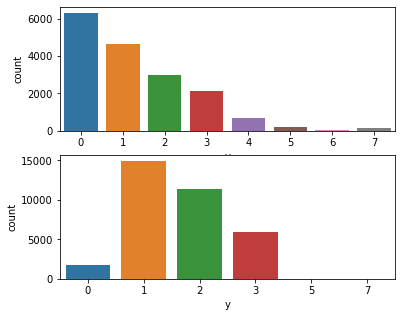

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
fig = plt.figure(figsize=(6., 5.))
fig.add_subplot(2, 1, 1)
sns.countplot(data=train, x='y')
fig.add_subplot(2, 1, 2)
sns.countplot(data=submission, x='y')
display(train.y.value_counts(normalize=True).sort_index())
display(submission.y.value_counts(normalize=True).sort_index())

In [16]:
submission.to_csv(os.path.join(OUTPUT_DIR, SUB_FILENAME), index=False)

In [17]:
metrics.loc['mean', 'train'], metrics.loc['mean', 'valid']

(0.5823520227604874, 0.2216234171089952)

In [18]:
print('"{}","{}","{:.6f}","{:.6f}","","{}"'.format(SUB_FILENAME, CV, metrics.loc['mean', 'train'], metrics.loc['mean', 'valid'], NOTE))

"018_submission.csv","Stratified-Kfold(K=5)","0.582352","0.221623","","全特徴量を使用したLightGBM.バランス指定、カテゴリ未指定"


In [19]:
%%time
for i, model in enumerate(models):
    with open(os.path.join(OUTPUT_DIR, f'model_fold{i + 1}.pickle'), 'wb') as f:
        pickle.dump(model, f)
        f.close()

Wall time: 664 ms


In [20]:
%%time
imp_df = pd.DataFrame()
for i, model in enumerate(models):
    final_estimator = model[-1]
    try:
        if hasattr(final_estimator, 'feature_importances_'):
            feature_importance = final_estimator.feature_importances_
        else:
            feature_importance = final_estimator.final_estimator.get_feature_importance()
            
        if hasattr(final_estimator, 'feature_name_'):
            feature_names = final_estimator.feature_name_
        else:
            feature_names = final_estimator.feature_names_
        imp_df_ = pd.DataFrame(
            {
                'feature': feature_names,
                'importance': feature_importance
            }
        )
        imp_df_['fold'] = i + 1
        imp_df = pd.concat([imp_df, imp_df_])
    except AttributeError:
        pass

if imp_df.shape[0] > 0:
    imp_df.to_csv(os.path.join(OUTPUT_DIR, 'feature_importances.csv'), index=False)

Wall time: 32 ms
